## Abordagem 2

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
diretorio_destino = '../vetores'

tfidf_title = joblib.load(f"{diretorio_destino}/tfidf_title.pkl")
tfidf_abstract = joblib.load(f"{diretorio_destino}/tfidf_abstract.pkl")
X = hstack([tfidf_title, tfidf_abstract])

In [3]:
eps = 0.5
min_samples = 10
batch_size = 8000
svd = TruncatedSVD(n_components=50, random_state=42)

In [4]:
X_reduced = svd.fit_transform(X)
print("Dimensionalidade reduzida com TruncatedSVD.")

Dimensionalidade reduzida com TruncatedSVD.


In [5]:
all_labels = []
for i in range(0, X_reduced.shape[0], batch_size):
    batch = X_reduced[i:i + batch_size]
    print(f"Processando batch {i // batch_size + 1}: {batch.shape[0]} itens.")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    batch_labels = dbscan.fit_predict(batch)
    
    # Ajustar índices dos clusters para evitar conflitos
    if len(all_labels) > 0:
        offset = max(all_labels) + 1
        batch_labels = [label + offset if label != -1 else -1 for label in batch_labels]
    all_labels.extend(batch_labels)

all_labels = np.array(all_labels)
print(f"Clusterização concluída. Total de clusters encontrados: {len(set(all_labels)) - (1 if -1 in all_labels else 0)}")

Processando batch 1: 8000 itens.
Processando batch 2: 8000 itens.
Processando batch 3: 8000 itens.
Processando batch 4: 8000 itens.
Processando batch 5: 8000 itens.
Processando batch 6: 8000 itens.
Processando batch 7: 8000 itens.
Processando batch 8: 8000 itens.
Processando batch 9: 8000 itens.
Processando batch 10: 8000 itens.
Processando batch 11: 8000 itens.
Processando batch 12: 8000 itens.
Processando batch 13: 8000 itens.
Processando batch 14: 8000 itens.
Processando batch 15: 8000 itens.
Processando batch 16: 8000 itens.
Processando batch 17: 8000 itens.
Processando batch 18: 8000 itens.
Processando batch 19: 8000 itens.
Processando batch 20: 8000 itens.
Processando batch 21: 8000 itens.
Processando batch 22: 8000 itens.
Processando batch 23: 8000 itens.
Processando batch 24: 8000 itens.
Processando batch 25: 8000 itens.
Processando batch 26: 8000 itens.
Processando batch 27: 8000 itens.
Processando batch 28: 8000 itens.
Processando batch 29: 8000 itens.
Processando batch 30: 8

In [ ]:
n_samples = 1000
indices_sample = np.random.choice(X_reduced.shape[0], n_samples, replace=False)
X_sample = X_reduced[indices_sample]
labels_sample = all_labels[indices_sample]

if len(set(labels_sample)) > 1:
    silhouette_avg = silhouette_score(X_sample, labels_sample)
    print(f"Silhouette Score (subamostra): {silhouette_avg}")
else:
    print("DBSCAN não formou clusters significativos na subamostra.")

/home/matt/anaconda3/envs/nlp-cluster/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


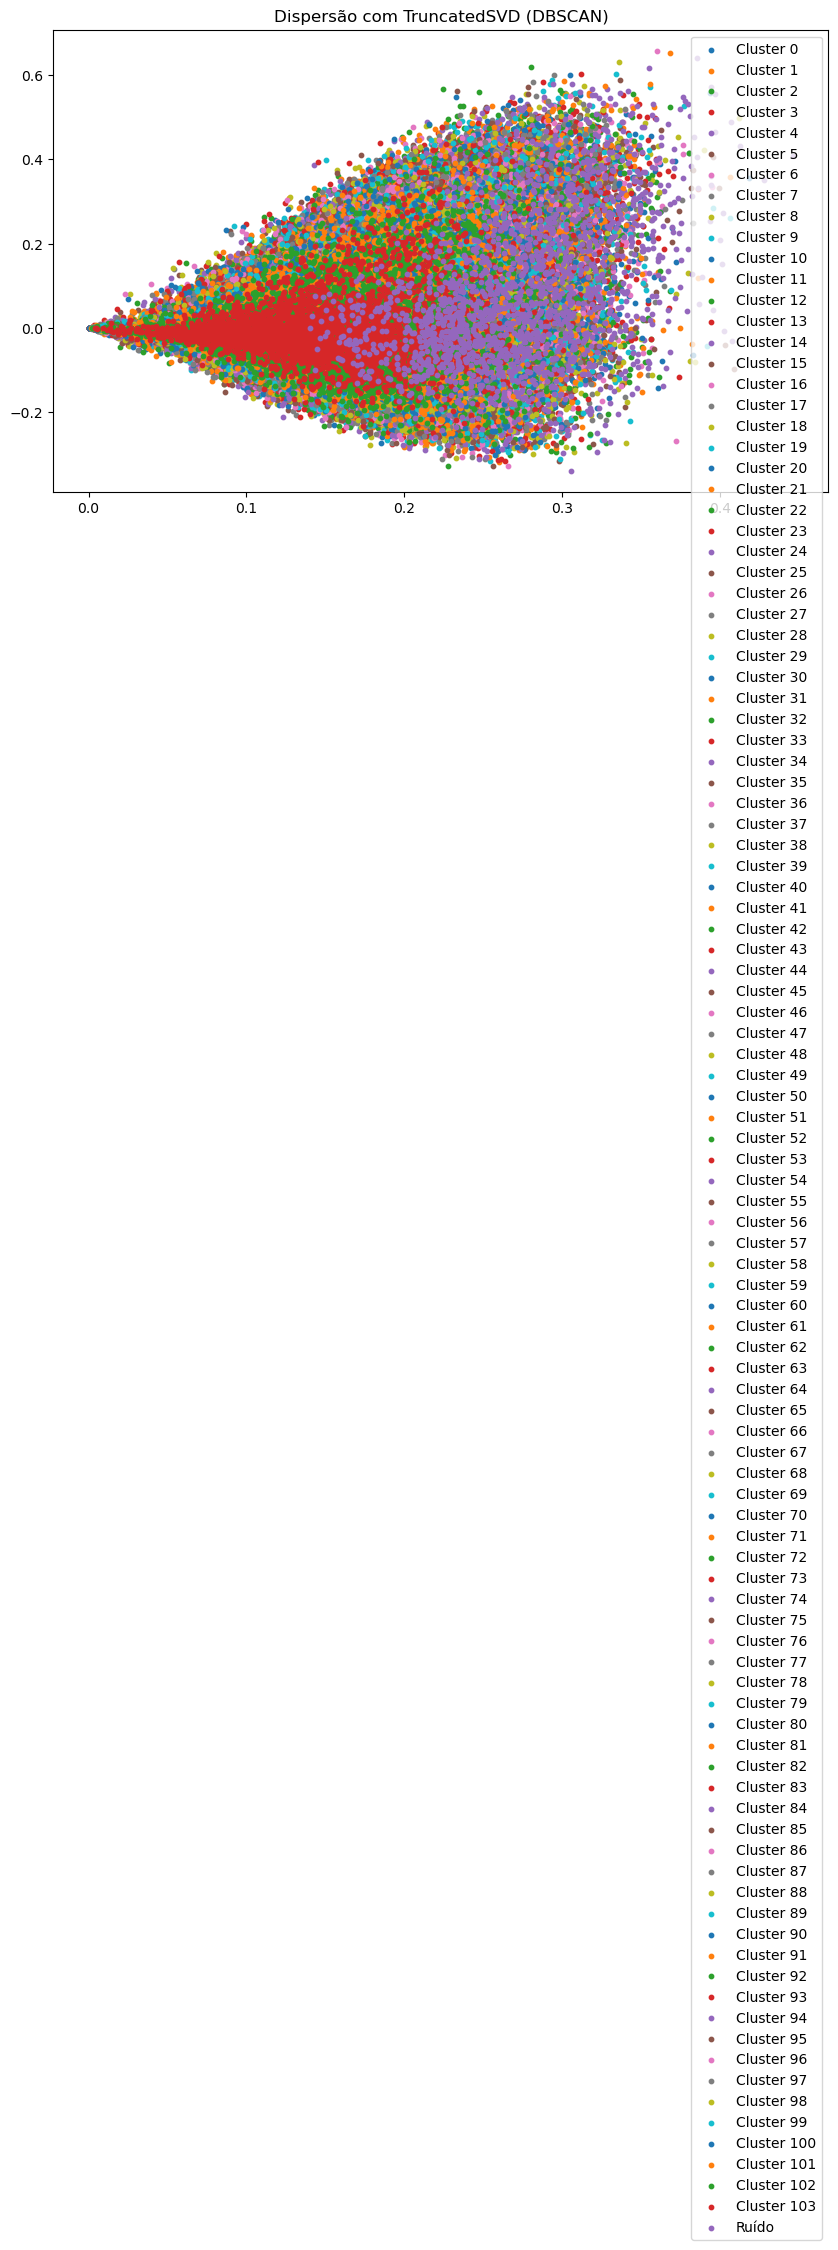

In [6]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_reduced_2d = svd_2d.fit_transform(X_reduced)

plt.figure(figsize=(10, 6))
unique_labels = set(all_labels)
for label in unique_labels:
    mask = all_labels == label
    plt.scatter(X_reduced_2d[mask, 0], X_reduced_2d[mask, 1], label=f'Cluster {label}' if label != -1 else "Ruído", s=10)
plt.title("Dispersão com TruncatedSVD (DBSCAN)")
plt.legend()
plt.show()

In [7]:
df = pd.read_parquet("../data/dblp-v10-processado.parquet")
df['cluster_dbscan'] = all_labels
for cluster in unique_labels:
    if cluster == -1:  # Ignorar ruído
        continue
    cluster_text = df[df['cluster_dbscan'] == cluster]['title'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras - Cluster {cluster}')
    plt.show()

: 

## Abordagem 1

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
diretorio_destino = '../vetores'

tfidf_title = joblib.load(f"{diretorio_destino}/tfidf_title.pkl")
tfidf_abstract = joblib.load(f"{diretorio_destino}/tfidf_abstract.pkl")
tfidf_combined = hstack([tfidf_title, tfidf_abstract])

In [ ]:
eps = 0.5
min_samples = 10
batch_size = 20000

In [4]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)

In [ ]:
all_labels = []

for i in range(0, tfidf_combined.shape[0], batch_size):
    batch = tfidf_combined[i:i+batch_size]
    print(f"Processando batch {i // batch_size + 1}: {batch.shape[0]} itens.")
    batch_labels = dbscan.fit_predict(batch)
    all_labels.extend(batch_labels)

In [6]:
all_labels = np.array(all_labels)
print(f"Clusterização concluída. Total de clusters encontrados: {len(set(all_labels)) - (1 if -1 in all_labels else 0)}")

Clusterização concluída. Total de clusters encontrados: 6


In [8]:
n_samples = 1000
X_sample, labels_sample = resample(tfidf_combined, all_labels, n_samples=n_samples, random_state=42)

In [11]:
if len(set(labels_sample)) > 1:
    silhouette_avg = silhouette_score(X_sample, labels_sample)
    print(f"Silhouette Score (subamostra): {silhouette_avg}")
else:
    print("DBSCAN não formou clusters significativos na subamostra.")

Silhouette Score (subamostra): -0.00110626495863015


In [9]:
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_sample.toarray())

: 

In [ ]:
# plt.figure(figsize=(10, 6))
# unique_labels = set(labels_sample)
# for label in unique_labels:
#     mask = labels_sample == label
#     plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], label=f'Cluster {label}' if label != -1 else "Ruído", s=10)
# plt.title("Dispersão com PCA (DBSCAN)")
# plt.legend()
# plt.show()

In [ ]:
# df = pd.read_parquet("../data/dblp-v10-processado.parquet")
# df['cluster_dbscan'] = all_labels

In [ ]:
# for cluster in unique_labels:
#     if cluster == -1:  # Ignorar ruído
#         continue
#     cluster_text = df[df['cluster_dbscan'] == cluster]['title'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
#     plt.figure(figsize=(8, 4))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f'Nuvem de Palavras - Cluster {cluster}')
#     plt.show()